In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
%matplotlib inline

$$q_1(t+1)=q_1(t)\left(1+v_1\left(a+2 c_1 Q_1-d_1-2\left(b+c_1\right) q_1(t)-b q_2(t)\right)\right)$$
$$q_2(t+1)=q_2(t)+\frac{v_2}{2\left(b+c_2\right)}\left(a+2 c_2 Q_2-d_2-2\left(b+c_2\right) q_2(t)-b q_1(t)\right)$$

### Figure 1 (from Paper)

In [2]:
init_params = {
    'a': 6,
    'b': 0.5,
    'c': np.array([2,1]), #c1, c2
    'd': np.array([0.5,1]), # d1, d2
    'v': np.array([0.1,1]), # v1, v2
    # Q to be calculated
}

$$Q_1=\frac{4\left(b+c_1\right)\left(\alpha-b c_2\right)\left(a\left(\alpha-2 b c_1\right)\right)+\alpha d_2-2 d_1\left(\alpha-b c_2\right)}{b \beta}$$

$$Q_2=\frac{\left(\alpha+b^2\right)\left(\alpha\left(3 b\left(a+d_1-2 d_2\right)+2 c_1\left(a+2 d_1-3 d_2\right)\right)-4 b c_2\left(b+c_1\right)\left(a+d_1-2 d_2\right)\right)}{b \beta}$$

$$\begin{aligned}
& \alpha=3 b^2+4 b\left(c_1+c_2\right)+4 c_1 c_2 \\
& \beta=\left(9 b+8 c_1\right) \alpha^2+8 b c_2\left(b+c_1\right)\left(2 b c_2-3 \alpha\right)
\end{aligned}$$


In [3]:
def calculate_Q_vals(a,b,c,d,v):
    alpha = 3*b**2 + 4*b*(c[0] + c[1]) + 4*c[0]*c[1]
    beta = (9*b + 8*c[0])*alpha**2 + 8*b*c[1]*(b + c[0])*(2*b*c[1] - 3*alpha)

    Q1 = 1/(b*beta)*(4*(b+c[0])*(alpha - b*c[1])*(a*(alpha - 2*b*c[0])) + alpha*d[1] - 2*d[0]*(alpha - b*c[1]))
    Q2 = 1/(b*beta)*( (alpha + b**2) * ( alpha*(3*b*(a + d[0] - 2*d[1]) + 2*c[0]*(a + 2*d[0] - 3*d[1])) - 4*b*c[1]*(b + c[0])*(a + d[0] - 2*d[1])))

    return np.array([Q1,Q2])

init_params['Q'] = calculate_Q_vals(*init_params.values())


In [4]:
@numba.jit(nopython=True)
def simulate(q_vals, iterations, a, b, c, d, v, Q):
    for i in range(1, iterations):
        q_vals[0, i] = q_vals[0,i-1]*(1 + v[0]*(a + 2*c[0]*Q[0] - d[0] - 2*(b + c[0])*q_vals[0,i-1] - b*q_vals[1, i-1]))
        q_vals[1, i] = q_vals[1,i-1] + v[1]/(2*(b + c[1]))*( a + 2*c[1]*Q[1] - d[1] - 2*(b + c[1])*q_vals[1, i-1] - b*q_vals[0, i-1])
    return None

In [5]:
def simulate_instance(q1_0, q2_0, init_params, iterations):

    q_vals = np.zeros((2, iterations))
    q_vals[:, 0] = q1_0, q2_0

    simulate(q_vals, iterations, *init_params.values())

    return q_vals

def plot_timeseries(q_vals):
    plt.plot(q_vals[0,-100:], '-o', label = 'Firm 1', linewidth = 0.5, markersize = 3)
    plt.plot(q_vals[1,-100:], '-o', label = 'Firm 2', linewidth = 0.5, markersize = 3)

    plt.legend()
    # show xticks from 900 to 1000
    plt.xticks(np.linspace(0, 100, 5),np.linspace(len(q_vals[0]) - 100, len(q_vals[0]), 5).astype(int))

    plt.xlabel('n')
    plt.ylabel('Production')
    plt.title('Time series of production ($q_1(t)$ and $q_2(t)$)')
    plt.savefig('Fig1.png', dpi = 500)
    plt.show()


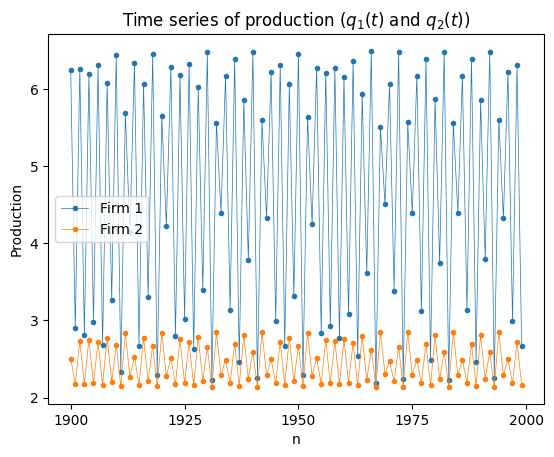

In [6]:
q10 = 1.
q20 = 1.0004

q_vals = simulate_instance(q10, q20, init_params, 2000)
plot_timeseries(q_vals)

### Figure 2 : Periodic and Chaotic Attractors

In [7]:
def plot_scatter(q_vals):
    plt.figure(figsize=(6,6))
    plt.scatter(q_vals[0,:], q_vals[1,:], s=1)
    plt.xlabel('$q_1$')
    plt.ylabel('$q_2$')
    plt.show()

def scatterplot_quad(qvals_list):
    fig, ax = plt.subplots(2,2, figsize=(8,7))
    ax = ax.flatten()
    for i, q_vals in enumerate(qvals_list):
        ax[i].scatter(q_vals[0,:], q_vals[1,:], s=0.1, color = 'purple')
        ax[i].set_xlabel('$q_1$')
        ax[i].set_ylabel('$q_2$')
        # set abcd labels
        ax[i].text(0.05, 0.95, f"({chr(97+i)})", transform=ax[i].transAxes, fontsize=10, va='top')
    
    fig.suptitle('Scatterplots of $q_1$ and $q_2$ for varying parameters', fontsize = 11)
    plt.tight_layout()
    plt.savefig('Fig2.png', dpi = 500)
    plt.show()

In [8]:
params1 = {
    'a': 6,
    'b': 0.5,
    'c': np.array([2.0, 1.0]), #c1, c2
    'd': np.array([0.5,1]), # d1, d2
    'v': np.array([0.1,1.6]), # v1, v2
}
params2 = {
    'a': 6,
    'b': 0.5,
    'c': np.array([2.0, 1.0]), #c1, c2
    'd': np.array([0.8,0.8]), # d1, d2
    'v': np.array([0.1, 1.6]), # v1, v2
}
params3 = {
    'a': 6,
    'b': 0.5,
    'c': np.array([2.0, 1.0]), #c1, c2
    'd': np.array([0.5,2]), # d1, d2
    'v': np.array([0.1,1]), # v1, v2
}
params4 = {
    'a': 6.0,
    'b': 0.6,
    'c': np.array([2.0, 1.0]), #c1, c2
    'd': np.array([0.5,1.0]), # d1, d2
    'v': np.array([0.1,1.6]), # v1, v2
}

params1['Q'] = calculate_Q_vals(*params1.values())
params2['Q'] = calculate_Q_vals(*params2.values())
params3['Q'] = calculate_Q_vals(*params3.values())
params4['Q'] = calculate_Q_vals(*params4.values())

q10 = 1.0
q20 = 1.0
q_vals1 = simulate_instance(q10, q20, params1, 10000)
q_vals2 = simulate_instance(q10, q20, params2, 10000)
q_vals3 = simulate_instance(q10, q20, params3, 10000)
q_vals4 = simulate_instance(q10, q20, params4, 10000)

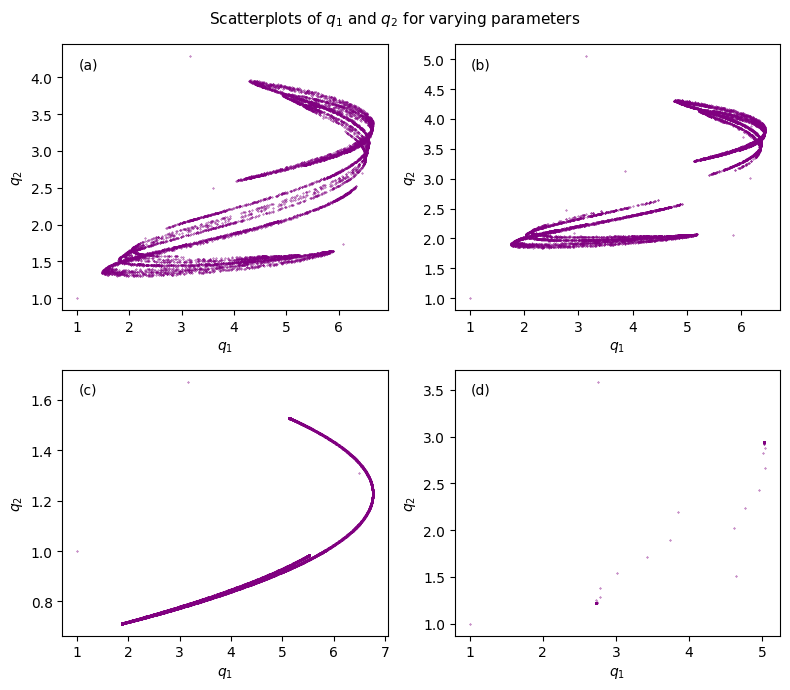

In [9]:
scatterplot_quad([q_vals1, q_vals2, q_vals3, q_vals4])

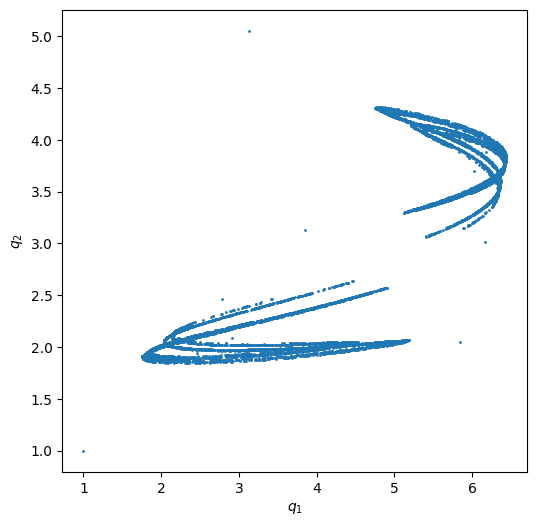

In [10]:
plot_scatter(q_vals2)

## Parameter Effects

### Variation of Single Parameter

Varying $a$

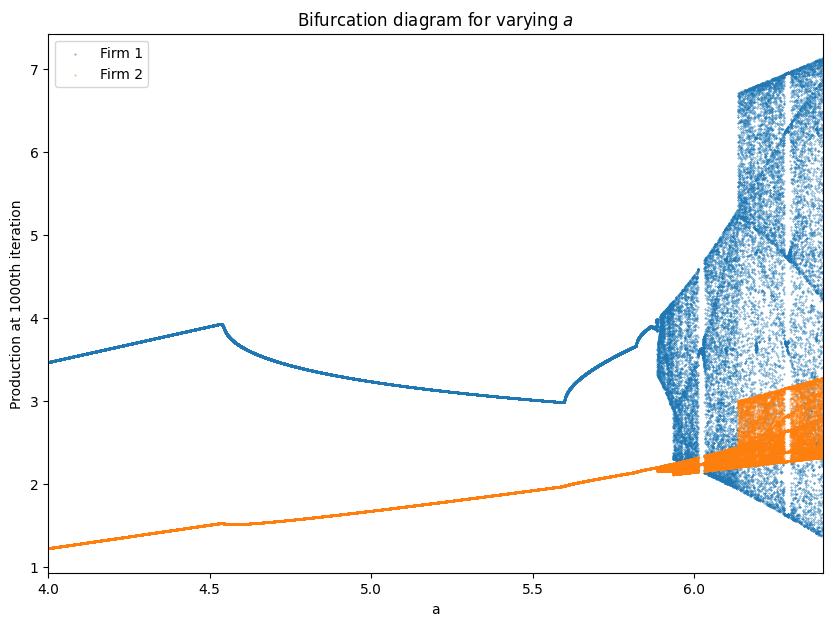

In [11]:
q10 = 1.0
q20 = 1.0

a_vals = np.linspace(4, 6.4, 90000)

list_of_params_a_varying = []
for a in a_vals:
    params = {
        'a': a,
        'b': 0.5,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)

plt.figure(figsize=(10,7))
plt.scatter(a_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(a_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.1)
# plt.ylim(0, 8)
plt.xlim(4, 6.4)
plt.legend()
plt.xlabel('a')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $a$')
plt.savefig('Fig3.png', dpi = 500)
plt.show()

Varying $b$


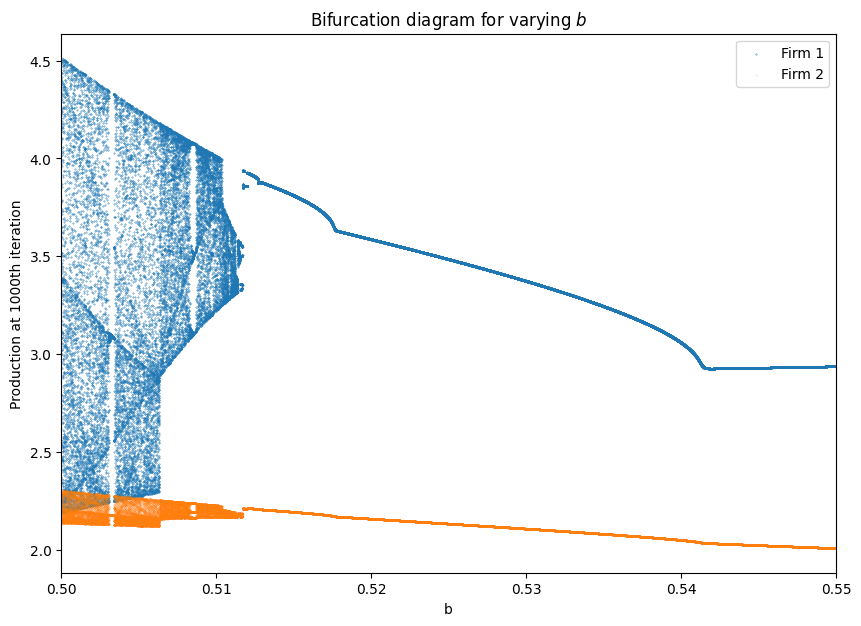

In [12]:
q10 = 1.0
q20 = 1.0

b_vals = np.linspace(0.5, 0.55, 90000)

list_of_params_a_varying = []
for b in b_vals:
    params = {
        'a': 6.0,
        'b': b,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(b_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(b_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.01)
# plt.ylim(-2.5, 12.5)
plt.xlim(0.5, 0.55)
plt.legend()
plt.xlabel('b')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $b$')
plt.savefig('Fig4.png', dpi = 500)
plt.show()

Varying $c_1$


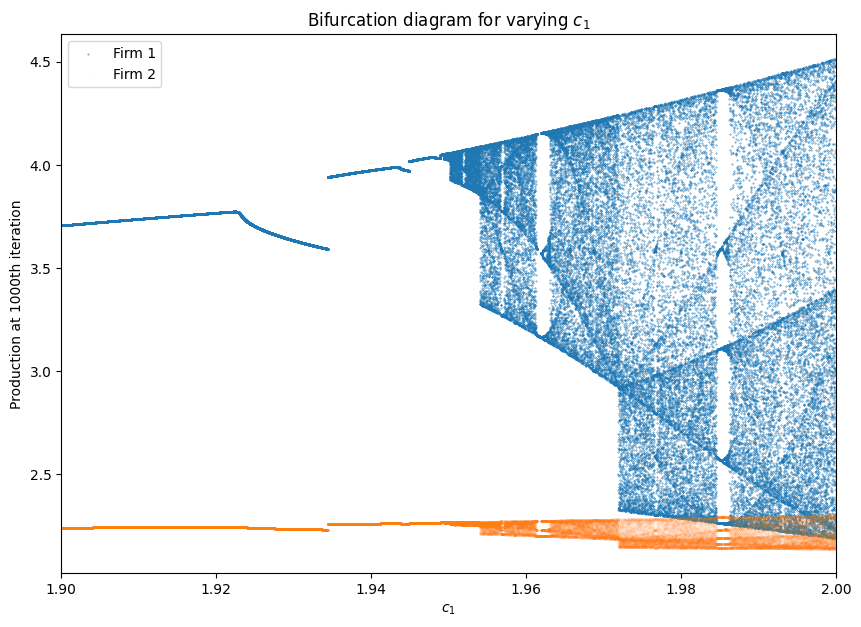

In [13]:
q10 = 1.0
q20 = 1.0

c_vals = np.linspace(1.90, 2, 90000)

list_of_params_a_varying = []
for c in c_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([c, 1]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(c_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(c_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.001)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$c_1$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $c_1$')
plt.xlim(1.90, 2)
plt.savefig('Fig5.png', dpi = 500)
plt.show()

Varying $c_2$

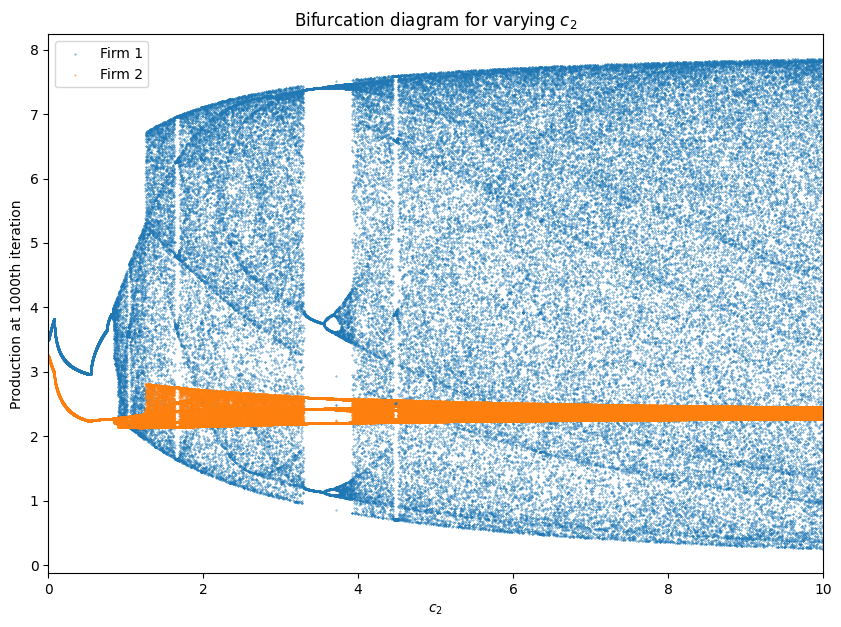

In [14]:
q10 = 1.0
q20 = 1.0

c_vals = np.linspace(0, 10, 90000)

list_of_params_a_varying = []
for c in c_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([2, c]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(c_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(c_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.1)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$c_2$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $c_2$')
plt.xlim(0, 10)
plt.savefig('Fig6.png', dpi = 500)
plt.show()

Varying 'd' parameter

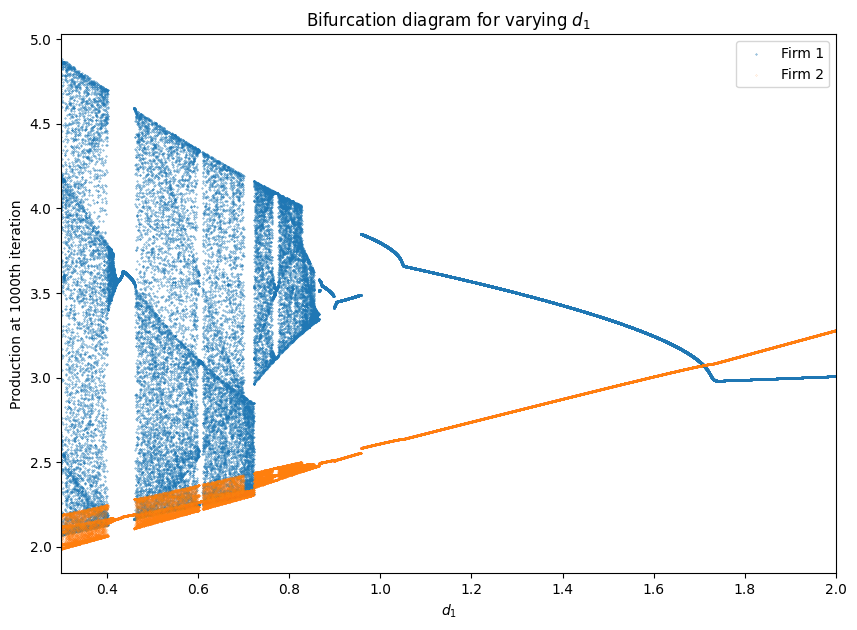

In [15]:
q10 = 1.0
q20 = 1.0

d_vals = np.linspace(0.3, 2.0, 90000)

list_of_params_a_varying = []
for d in d_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([d,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(d_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(d_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.01)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$d_1$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $d_1$')
plt.xlim(0.3, 2.0)
plt.savefig('Fig7.png', dpi = 500)
plt.show()

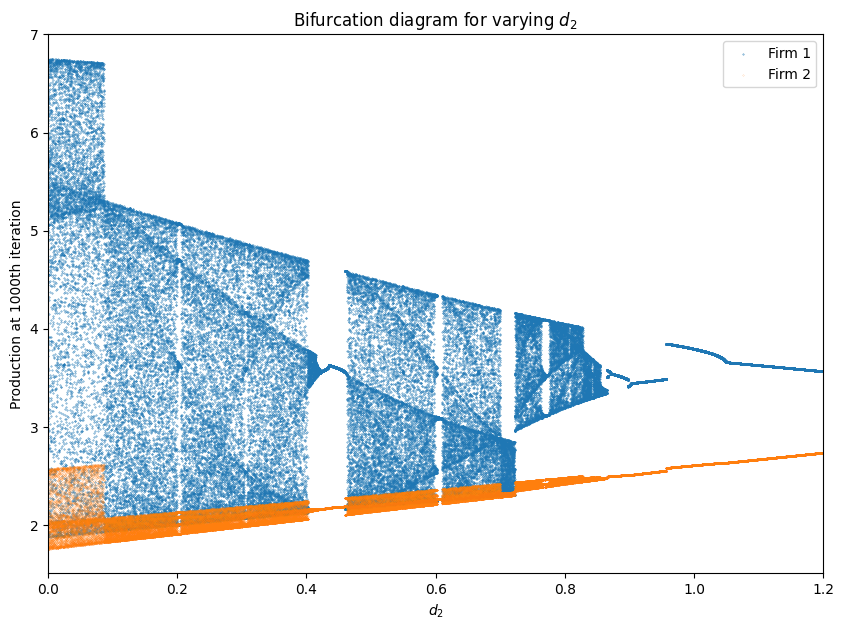

In [16]:
q10 = 1.0
q20 = 1.0

d_vals = np.linspace(0, 1.2, 90000)

list_of_params_a_varying = []
for d in d_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([d,1]), # d1, d2
        'v': np.array([0.1,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(d_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(d_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.01)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$d_2$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $d_2$')
plt.xlim(0, 1.2)
plt.savefig('Fig8.png', dpi = 500)
plt.show()

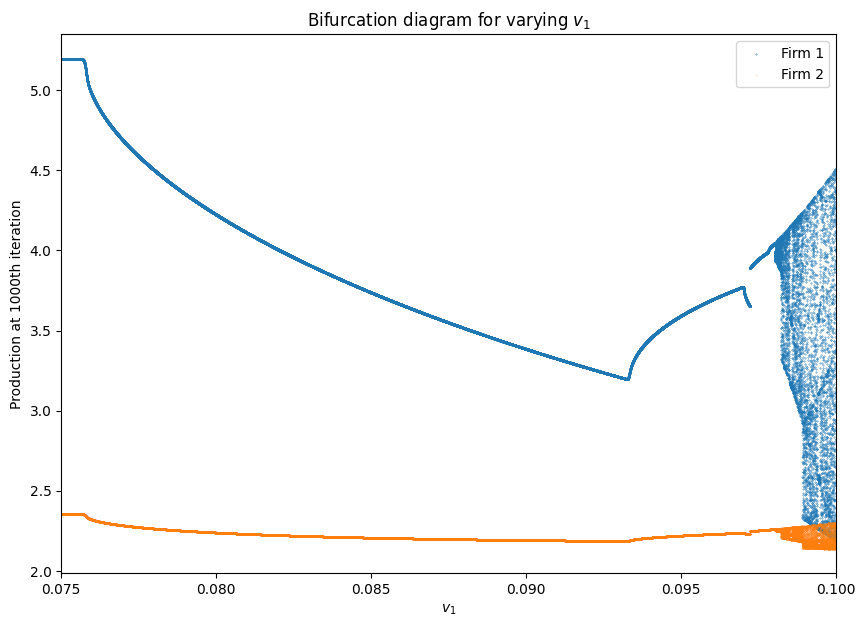

In [17]:
q10 = 1.0
q20 = 1.0

v_vals = np.linspace(0.075, 0.1, 90000)

list_of_params_a_varying = []
for v in v_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([v,1]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(v_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(v_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.01)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$v_1$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $v_1$')
plt.xlim(0.075, 0.1)
plt.savefig('Fig9.png', dpi = 500)
plt.show()

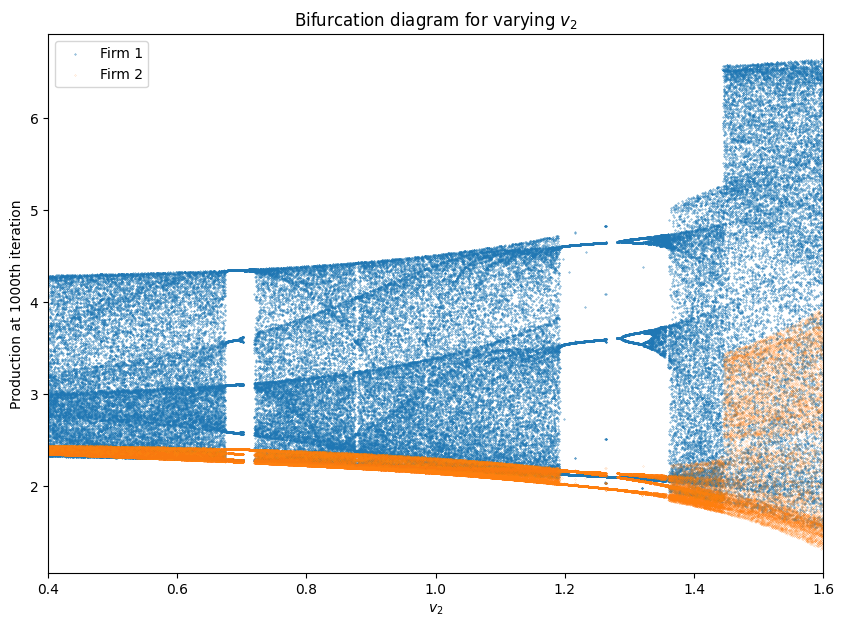

In [18]:
q10 = 1.0
q20 = 1.0

v_vals = np.linspace(0.4, 1.6, 90000)

list_of_params_a_varying = []
for v in v_vals:
    params = {
        'a': 6.0,
        'b': 0.5,
        'c': np.array([2, 1]), #c1, c2
        'd': np.array([0.5,1]), # d1, d2
        'v': np.array([0.1, v]), # v1, v2
    }
    params['Q'] = calculate_Q_vals(*params.values())
    list_of_params_a_varying.append(params)

q_max_vals = []
for params in list_of_params_a_varying:
    q_vals = simulate_instance(q10, q20, params, 1000)
    # q_max_vals.append([np.max(q_vals[0,:]), np.max(q_vals[1,:])])
    q_max_vals.append([q_vals[0, -1], q_vals[1, -1]])

q_max_vals = np.array(q_max_vals)


### PLOTTING ###
plt.figure(figsize=(10,7))
plt.scatter(v_vals, q_max_vals[:,0], label = 'Firm 1', s = 0.1)
plt.scatter(v_vals, q_max_vals[:,1], label = 'Firm 2', s = 0.01)
# plt.ylim(-2.5, 12.5)
plt.legend()
plt.xlabel('$v_2$')
plt.ylabel('Production at 1000th iteration')
plt.title('Bifurcation diagram for varying $v_2$')
plt.xlim(0.4, 1.6)
plt.savefig('Fig10.png', dpi = 500)
plt.show()